# Bayes By Backprop - A comparative study


**Harvard University**<br>
**Fall 2018**<br>

### Collaborators

** Christian Kaas, Thomas Kulalert, Alexander Noll, Karma Tarap**  

# Abstract

In this tutorial we introduce the "Bayes by Backprop" algorithm. It is an algorithm to make the calculation of the posterior weight distribution of neural networks tractable. The main idea of this method is to combine two standard methods, one from the Bayesian real and one often employed in frequentist machine learning, but not specific to it:

1. Variational inference: this is a standard technique to approximate the posterior distribution in situations that are otherwise intractable. The fundamental idea is very simple: we can't do the posterior calculations (or sampling, for that matter) exactly, so we approximate the posterior with distributions we know.
2. Backpropagation (a.k.a. gradient descent): this is the default technique to optimize the weights in neural networks.

It is shown that we can use backpropagation to perform variational inference.

We use "Bayes by Backprop" on two different datasets:

1. A simulated dataset from the scikit learn datasets.
2. MNIST

We compare Bayes By Backprop to the more general Automatic Differentiation Variational Inference (ADVI) [2, 3] algorithm and show that Bayes By Backprop is a special case of it. Finally, we compare the performance of this approach to *Concrete Dropout* [4].


In [10]:
import numpy as np

from matplotlib import cm
import matplotlib.pyplot as plt

import scipy.stats
import seaborn as sns
import pandas as pd
import pymc3 as pm

from sklearn.datasets import make_classification

import theano
from theano import shared
import theano.tensor as T

from time import time

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

/Users/alex/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/alex/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/alex/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/alex/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/alex/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/alex/anaconda3/lib/python3.6/im

Populating the interactive namespace from numpy and matplotlib


/Users/alex/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Introduction

## What are Bayesian neural networks

We'll be very brief here as a lot of the material has alredy been covered in class. The fundamental idea in **Bayesian neural networks** is that the weights ${\bf w}$ connecting the different layers have their own **posterior distribution** $p({\bf w} \vert \mathcal D) \propto p(D\vert {\bf w}) p({\bf w})$, given a dataset $\mathcal D$ and a prior $p({\bf w})$. This idea is very natural from a Bayesian point of view. The weights can be considered **latent variables** and thus should have their own distribution.

## Why Bayesian neural nets

The above might motivate why putting a distribution on the weight parameteres is natural, the question remains, though, why we would want to do that. After all, maximum-likelihood neural networks fitted with variations of gradient descent are very successful in numerous applications.

1. The first reason is very practical: putting a prior on the weights, that might constrain them to be relatively close to zero, has a natural **regularising** effect. 
2. The predictions made by the neural network will be less affected by overfitting: predictions are made as $p(y^* \vert \mathcal D) = \int_{\bf w}p(y^*\vert {\bf w}) p({\bf w} \vert \mathcal D)$ and thus can be considered an **ensemble** of neural networks. We expect such an ensemble of neural networks to be less sensitive to small changes in the data $\mathcal D$ and small changes $y^* \rightarrow y^* + \epsilon$.
3. One of the key points about Bayesian neural nets is that they allow to get **uncertainties on the predictions**. Note that by the equation above, we get a posterior predictive **distribution $p(y^*)$**. Having uncertainties in predictions has many applications (for example, we might want to use predictions only if the model is very certain about the prediction).
4. This is more of a theoretical motiviation, but related to point 2. above. We learned that in high dimensional spaces, most of the **typical set** of the posterior distribution **is not at the maximum**, but rather around the maxmium (basically, we have to strike a balance between having **volume** and having **high density**). So even though the posterior density might be high near the maximum, the maximum is not in the typical set. (This is a highly suggestive comment that is easy to attack. After all, recent research indicates that optimization algorithms usually don't converge to local maxima, but rather move along "critical directions". The intuition is that in a high-dimensional space the probability of the Hessian matrix having only positive or negative eigenvalues is very small).

## Problems with naive approach (sampling)

In this short section, we'll show that naive MCMC for the weights of a Bayesian Neural Network is doomed to fail. We try applying Bayesian nets to a relatively simple dataset shown below. What's interesting about this dataset is that it's easier in some regions than other.

Text(0.5, 1.0, 'Artifical dataset')

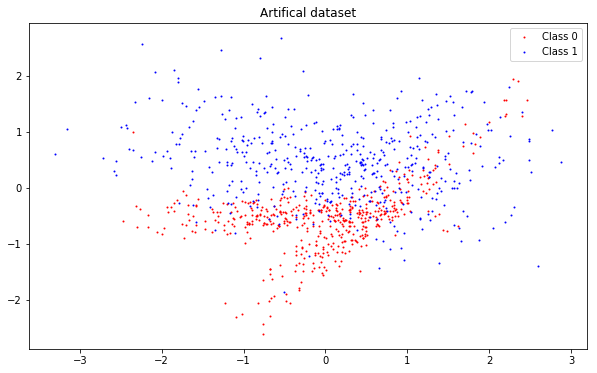

In [6]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                           class_sep=0.5, random_state=0)

plt.scatter(X[y==0, 0], X[y==0, 1], s=1, c='red', label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], s=1, c='blue', label='Class 1')
plt.legend()
plt.title("Artifical dataset")

### A small neural network that works

After defining this dataset, let's try to do the classification with Bayesian neural nets. We write the model in PyMC3.

In [7]:
n_hidden = 10

with pm.Model() as nn_simple:
    # Weights from input to hidden layer
    x = shared(X)
    w_in_h = pm.Normal('w_in_h', mu=0, sd=1, shape=(2, n_hidden))
    
    # Activations in hidden layer
    activation = pm.math.tanh(pm.math.dot(x, w_in_h))
    
    # Weights from hidden layer to output
    w_h_out = pm.Normal('w_h_out', mu=0, sd=1, shape=(n_hidden))
    logits = pm.math.dot(activation, w_h_out)
    
    # Likelihood
    obs = pm.Bernoulli('obs', logit_p=logits, observed=y)
    
    # Sampling
    trace = pm.sample(1000)
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_h_out, w_in_h]
Sampling 2 chains: 100%|██████████| 3000/3000 [02:25<00:00, 20.63draws/s]
The number of effective samples is smaller than 25% for some parameters.


We see that even this very small problem (1000 datapoints, 2 dimensions, 10 hidden units) already takes considerable time. Let's see whether it worked. In a real world example, we'd have to split the dataset before, but in this case we can simply generate new data!

100%|██████████| 1000/1000 [00:01<00:00, 681.15it/s]


Text(0.5, 1.0, 'Posterior predictive ')

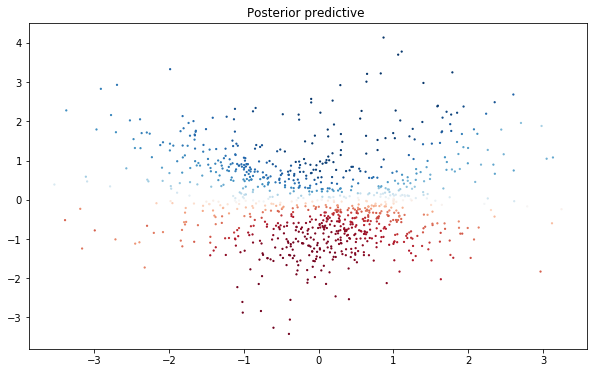

In [8]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                           class_sep=0.5, random_state=1)

x.set_value(X)

with nn_simple:
    ppc_samples = pm.sample_ppc(trace)
    
pred = ppc_samples['obs'].mean(axis=0)
cmap = cm.get_cmap('RdBu')
colors = [cmap(z) for z in pred]
plt.scatter(X[:, 0], X[:, 1], s=1.5, c=colors)
plt.title("Posterior predictive ")

The result makes sense. Also note that the neural network is rather uncertain in the boundary regions. Let's extend this plot and do predictions not at test points, but rather at a grid of points:

100%|██████████| 1000/1000 [00:04<00:00, 227.94it/s]


Text(0.5, 1.0, 'Predicted class probabilities')

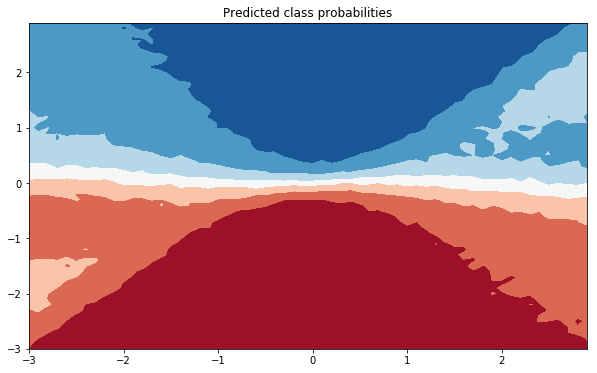

In [9]:
xy = np.mgrid[-3:3:0.1, -3:3:0.1]
X = xy.reshape(2, -1).T
x.set_value(X)

with nn_simple:
    ppc_samples = pm.sample_ppc(trace)

y = ppc_samples['obs'].mean(axis=0)
y = y.reshape(xy.shape[1]xq, xy.shape[2])
cmap = cm.get_cmap('RdBu')
plt.contourf(xy[0], xy[1], y, cmap=cmap)
plt.title("Predicted class probabilities")

100%|██████████| 1000/1000 [00:04<00:00, 248.77it/s]


Text(0.5, 1.0, 'Predicted class probabilities')

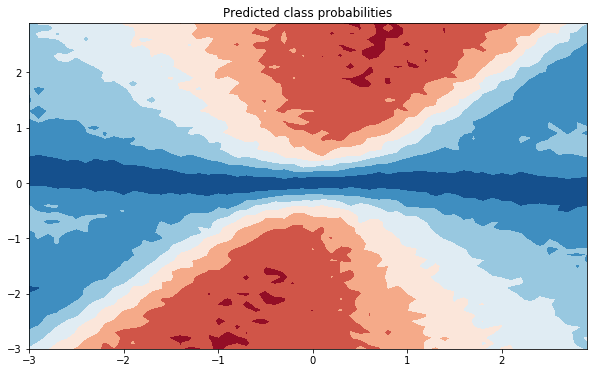

In [12]:
xy = np.mgrid[-3:3:0.1, -3:3:0.1]
X = xy.reshape(2, -1).T
x.set_value(X)

with nn_simple:
    ppc_samples = pm.sample_ppc(trace)

y = ppc_samples['obs'].std(axis=0)
y = y.reshape(xy.shape[1], xy.shape[2])
cmap = cm.get_cmap('RdBu')
plt.contourf(xy[0], xy[1], y, cmap=cmap)
plt.title("Predicted uncertainties")

Note that the uncertainty is captured pretty well by the Bayesian neural network.

### Scalability of MCMC

After this simple check that everything works, let's look a bit at the scalability. We'll try to scale up the experiment in one dimension, namely the size of the dataset. One could think about making the problem bigger in two other dimensions as well:

1. Bigger dataset
2. More hidden units
3. More hidden layers

We'll see that that Markov Chain Monte Carlo fails relatively quickly and we won't be able to reach data sizes customary in today's state-of-the-art applications.

#### Dataset size

In [8]:
n_data = [10, 100, 1000, 10000, 100000]
n_samples = [1000, 1000, 1000, 100, 10]

results = pd.DataFrame()
for n, m in zip(n_data, n_samples):
    X, y = make_classification(n_samples=n, n_features=2, n_informative=2, n_redundant=0,
                               class_sep=0.5, random_state=0)
    
    n_hidden = 10
    
    start_time = time.time()

    with pm.Model() as nn_simple:
        # Weights from input to hidden layer
        x = shared(X)
        w_in_h = pm.Normal('w_in_h', mu=0, sd=1, shape=(2, n_hidden))

        # Activations in hidden layer
        activation = pm.math.tanh(pm.math.dot(x, w_in_h))

        # Weights from hidden layer to output
        w_h_out = pm.Normal('w_h_out', mu=0, sd=1, shape=(n_hidden))
        logits = pm.math.dot(activation, w_h_out)

        # Likelihood
        obs = pm.Bernoulli('obs', logit_p=logits, observed=y)

        # Sampling
        trace = pm.sample(m, tune=m)

    end_time = time.time()
    
    results = results.append([{'n_data': n, 'time': end_time - start_time, 'n_samples': m}])

results['time_per_sample'] = results['time'] / results['n_samples']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_h_out, w_in_h]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1382.73draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_h_out, w_in_h]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:12<00:00, 634.56draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_h_out, w_in_h]
Sampling 4 chains: 100%|██████████| 8000/8000 [03:14<00:00, 41.21draws/s]
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_h_out, w_in_h]
Sampling 4 chains: 100%|██████████| 800/800 [04:15<00:00,  1.08s/draws]
The acceptance probability does

Text(0,0.5,'Time to generate posterior sample')

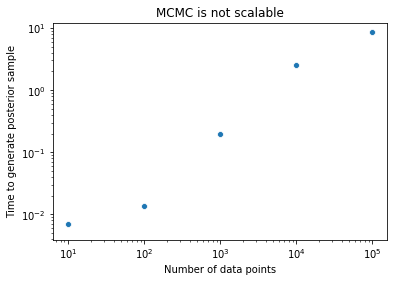

In [15]:
sns.scatterplot('n_data', 'time_per_sample', data=results)
plt.xscale('log')
plt.yscale('log')
plt.title("MCMC is not scalable")
plt.xlabel("Number of data points")
plt.ylabel("Time to generate posterior sample")

This small experiment makes it clear that it's not possible, or at least very hard, to scale up MCMC to realistic dataset sizes (and parameter space sizes).

Experimenting with the number of hidden units shows that the problem is even more severe.

## Solution with Variation inference

We'll show that variational inference solves this problem. The concept of variational inference is explained in the next chapter.

Note that pymc3 is able to perform **automatic differentiation variation inference (ADVI)**. This is the key technological development that allows us to do large scale Bayesian inference. We'll show how to use it here. We just run this one code cell that takes

+ 10'000 input data
+ two hidden layers
+ with 100 hidden units each

This would've been impossible to solve with MCMC. It also runs for a while (35 min on a 2016 MacBook Pro), but that's not too bad.

In [2]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                           class_sep=0.5, random_state=0)
    
n_hidden = 10
    
with pm.Model() as nn_simple:
    # Weights from input to hidden layer
    x = shared(X)
    w_in_h = pm.Normal('w_in_h', mu=0, sd=1, shape=(2, n_hidden))

    # Activations in hidden layer
    activation = pm.math.tanh(pm.math.dot(x, w_in_h))
    
    # Weights from hidden to hidden
    w_h_h = pm.Normal('w_h_h', mu=0, sd=1, shape=(n_hidden, n_hidden))
    activation = pm.math.tanh(pm.math.dot(activation, w_h_h))

    # Weights from hidden layer to output
    w_h_out = pm.Normal('w_h_out', mu=0, sd=1, shape=(n_hidden))
    act_out = pm.math.dot(activation, w_h_out)

    # Likelihood
    obs = pm.Bernoulli('obs', logit_p=act_out, observed=y)

    # Sampling
    inference = pm.ADVI()
    approx = pm.fit(n=10000, method=inference)

Average Loss = 726.43: 100%|██████████| 50000/50000 [02:04<00:00, 401.88it/s]
Finished [100%]: Average Loss = 726.29


Text(0.5, 1.0, 'Posterior predictive ')

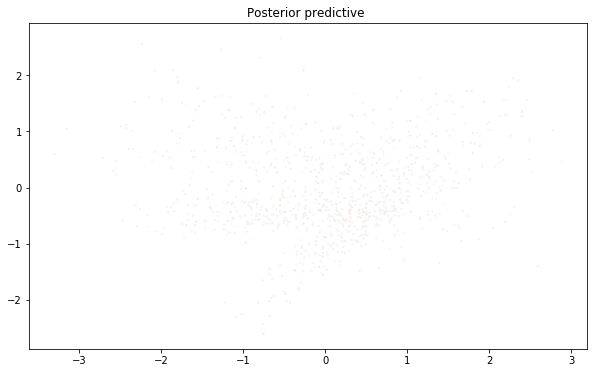

In [3]:
trace = approx.sample(draws=5000)
with nn_simple:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=False)
    
pred = ppc['obs'].mean(axis=0)
cmap = cm.get_cmap('RdBu')
colors = [cmap(z) for z in pred]

plt.scatter(X[:, 0], X[:, 1], s=1.5, c=colors)
plt.title("Posterior predictive ")

 13%|█▎        | 663/5000 [00:06<01:11, 60.85it/s]


Text(0.5, 1.0, 'Predicted class probabilities')

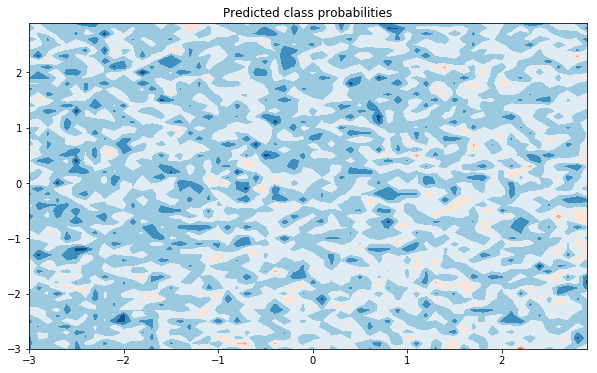

In [5]:
xy = np.mgrid[-3:3:0.1, -3:3:0.1]
X = xy.reshape(2, -1).T
x.set_value(X)

with nn_simple:
    ppc_samples = pm.sample_ppc(trace)

y = ppc_samples['obs'].std(axis=0)
y = y.reshape(xy.shape[1], xy.shape[2])
cmap = cm.get_cmap('RdBu')
plt.contourf(xy[0], xy[1], y, cmap=cmap)
plt.title("Standard deviation of probability")

# Variational inference

In Bayesian statistics we are interested in computing the posterior probability distribution $p(\theta\vert \mathcal D)$ given some dataset $\mathcal D$. Here $\theta$ are *latent variables* like weights in a linear regression, hyperprior parameters in hierarchical models or probabilities of a datapoint belonging to a certain cluster in Gaussian Mixture models.

Computing this posterior probability is in general a **hard problem** and may or may not be tractable. There's various procedures we can use to calculate the posterior "distribution".

1. **Exact inference**: in some models, for example conjugate prior-likelihood pairs, we can calculate an exact posterior probability $p(\theta\vert \mathcal D)$. While this is the "best way" of doing inference, the challenge is that there are only a restricted number of exactly solvable models and thus our ability to model data accurately is quite restricted. Also, it usually requires detailled mathematical analysis to come up with the analytical formula.
2. **Markov Chain Monte Carlo**: this is usually the preferred way to do Bayesian inference as it allows us to draw samples and compute any quantity we are interested in arbitrarily accurately. The problem with  MCMC is that, at least [until recently](https://arxiv.org/abs/1811.02091), for high-dimensional parameter problems it has been too slow to compute samples. We'll see MCMC for neural networks failing in this tutorial.
3. **Variational inference**: this is the main technique used in this tutorial. The main idea of variational inference is to use known distribution to approximate the posterior distribution.
4. **Expecatation maximization**: EM gives a point estimate using alternating an expectation and maximization step. It is the least desired of the four methods above, as it does not give uncertainties in the latent variables.

## What is variational inference?

As described above, variational inference is a technique to use a known distribution such as a multivariate normal, to approximate the unknown posterior. What do we mean by "approximating the posterior distribution"? Denote by $p({\bf w} \vert \mathcal D) \propto p({\bf w}) p(\mathcal D \vert {\bf w})$ the posterior distribution, which is a function of the latent variables $\theta$. We write

$$
p({\bf w} \vert \mathcal D) \approx q({\bf w} \vert \theta)
$$

Usually, we assume a factorization $q({\bf w} \vert \theta) = \prod_i q_i(w_i\vert \theta_i)$ to make the problem more tractable.

So, how do we define the approximation? We approximate the posterior distribution $p({\bf w} \vert \mathcal D)$ by minimizing the KL divergence between $q({\bf w} \vert \theta)$ and $p({\bf w} \vert \mathcal D)$

$$
\theta_{opt} = \arg \min_\theta \text{KL}(q({\bf w} \vert \theta) \Vert p({\bf w} \vert \mathcal D)) \:.
$$

# Bayes by backprop

In this section, we'll see how variational inference applied to neural networks lead to the "Bayes by Backprop" algorithm if we assume a certain distribution for the weights of the neural network. This section follows very closely the [original paper](https://arxiv.org/pdf/1505.05424.pdf).

## Derivation

As we saw in the chapter on variational inference, the fundamental idea is to choose a family of distributions $q(\bf w\vert \theta)$ over the weights $\bf w$ of the neural network, parametrized by $\theta$. Then we find the parameters $\theta$ within the given family $q$ that best approximates the posterior $p(\bf w\vert \mathcal D)$, i.e. we choose the best parameters $\theta$.

It's important to note that we do not have to worry about "overfitting" when we choose the family $q$. After all, it's just approximating the posterior, so even if it has many parameters, it can't overfit.

What do we mean by "best approximation"? It's the parameter values that minimize the Kullback-Leibler divergence between $q(\bf w \vert \theta)$ and $p(\bf w\vert \mathcal D)$:

$$
\theta^* = \arg \min_{\theta} \text{KL}(q({\bf w}\vert \theta) \Vert p( {\mathbf w}\vert \mathcal D))= 
\\
= \arg \min_{\theta} \int q({\bf w} \vert \theta) \ln \frac{q( {\bf w} \vert \theta)}{p({\bf w}\vert \mathcal D)} d {\bf w} =  \\
= \arg \min_{\theta} \text{KL}(q({\bf w}\vert \theta) \Vert p({\bf w})) - \mathbb E_{q({\bf w} \vert \theta)} \left[P( {\mathbf w} \vert \mathcal D ) \right]
$$

In practice we'll directly use the upper optimzation form, the one on the lower line is interesting from a theoretical point of view. It shows the tradeoff between simplicity (approximate the prior with $q({\bf w} \vert \mathcal \theta)$) and a likelihood cost.

How do find the optimal parameters $\theta$ in the optimization above? **Batch gradient descent**. We can use it because of the following **Proposition**. When reading it, think of $q(\epsilon)$ as a multivariate normal $\mathcal N(0, I)$, think of $\bf w$ as the n-dimensional weight vector of the neural network. Then, with $\theta = (\mu, \rho) \in \mathbb R^n \times \mathbb R^n$, $\bf w = \mu + \log(1+\exp(\rho)) \epsilon = t(\theta, \epsilon)$, i.e. the weights follow a shifted and normal distribution with diagonal covariance matrix.

> **Proposition**: Let $\epsilon$ be a random variable with density $q(\epsilon)$ and let $\bf w = t(\theta, \epsilon)$ be a deterministic function. Furthermore, assume that $q(\epsilon) d \epsilon = q(\theta \vert \omega) d \theta$. Then for a function $f$ with continuous derivaties

$$
\frac{\partial}{\partial \theta} \mathbb E_{q(\bf w\vert \theta)} f({\bf w}, \theta) = \mathbb E_{q(\epsilon)} \left( \frac{\partial f}{\partial {\bf w}} \frac{\partial {\bf w}}{\theta} + \frac{\partial f}{\partial \theta}\right)
$$

In the optimization approach, we want to calculate the derivative of an expectation, and by the proposition we can use the expectation of the derivative instead. We approximate the expectation of the derivative via the law of large numbers and use a sample mean.

## Variational posterior

We now describe the algorithm to caluclate the variation posterior. Note that the form $\sigma = \log(1 + \exp(\rho))$ is used so that $\rho \in \mathbb R$ always leads to a valid (i.e. positive) value of the standard deviation $\sigma$. This is necessary so that we don't have to worry about going into "forbidden" regions in the gradient descent step. So, let's suppose we have an n-dimensional weight vector $\bf w$ and let $(\mu, \rho) \in \mathbb R^n \times \mathbb R^n$. Then ${\bf w} = \mu + \log(1 + \exp \rho) \epsilon$.

1. Sample $\epsilon \sim \mathcal N(0, I)$, where $I$ is the n-dimensional unit matrix.
2. Compute ${\bf w} = \mu + \log(1 + \exp \rho) \epsilon$
3. Set $\theta = (\mu, \rho)$
4. Let $f({\bf w}, \theta) = \log q({\bf w} \vert \theta) - \log P({\bf w}) P(\mathcal D \vert {\bf w})$
5. Calculate the gradient $\Delta_\mu = \frac{\partial f}{\partial {\bf w}} + \frac{\partial f}{\partial \mu}$
6. Calculate the gradient $\Delta_{\rho} = \frac{\partial f}{\partial {\bf w}}\frac{\epsilon}{1 + \exp(-\rho)} + \frac{\partial f}{\partial \rho}$
7. Update the parameters $\mu \rightarrow \mu + \alpha \Delta_\mu$, $\rho \rightarrow \rho + \alpha \Delta_\rho$

Note that with software libraries like PyTorch, the gradients of $f$ are easy to calculate.



## Description of prior

In principle we are now free to use **any prior** that we wish to use. The authors of [1] suggest to use a prior that is a **mixture of two diagonal Gaussians**,

$$
P({\bf w}) = \prod_j \pi \mathcal N({\bf w}_j \vert 0, \sigma_1^2) + (1 - \pi) N({\bf w}_j \vert 0, \sigma_2^2)
$$

One of the two Gaussians has a relatively large variance $\sigma_1 > \sigma_2$, giving rise to a larger tail in the distribution. The second Gaussian should have a very small variance $\sigma_2 \ll 1$. Let's look at examples:

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


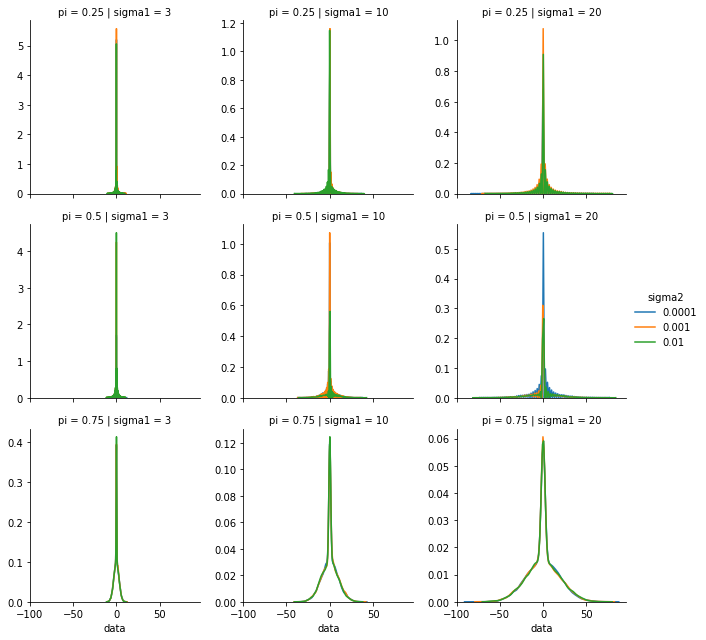

In [41]:
sigma1 = [3, 10, 20]
sigma2 = [0.0001, 0.001, 0.01]
pi = [0.25, 0.5, 0.75]
n = 10000

samples = pd.DataFrame()

for _sigma1 in sigma1:
    for _sigma2 in sigma2:
        for _pi in pi:
            n_cluster_1 = np.random.binomial(n=n, p=_pi)
            c1 = np.random.normal(scale=_sigma1, size=n_cluster_1)
            c2 = np.random.normal(scale=_sigma2, size=n-n_cluster_1)
            sample = np.append(c1, c2)
            sample_df = pd.DataFrame({'sigma1': _sigma1, 'sigma2': _sigma2, 'pi': _pi, 'data': sample})
            samples = samples.append(sample_df)

g = sns.FacetGrid(row='pi', col='sigma1', hue='sigma2', data=samples, sharey=False)
g.map(sns.distplot, 'data', hist=False).add_legend()

We see that $\sigma_1$ controls how wide the tail of the distribution is. $\pi$ controls how much mass goes into the tail distribution (the larger $\pi$, the more weight goes in the tail). With the parameter range we set up here, varying $\sigma_2$ does not have a big impact. The main point about this parameter is that it is close to zero.

There's no particular reason to choose this prior except that it is convenient to work with and puts much mass at weights near zero.

## Minibatches and KL reweighting

The authors of [1] introduce another hyperparameter that can be tuned. Note that the main point of using batch gradient descent is that it gives an unbiased estimate of the KL divergence. 

We can modify the standard batch gradient procedure to weight the complexity cost and the likelihood differently, depending on batch.

Let us make this more precise. Suppose we have split the dataset $\mathcal D$ into $M$ batches $\mathcal D_i$. Pick $M$ weights $\pi_i > 0$, such that $\sum_i \pi = 1$. Then we can give weight to the complexity cost and likelihood cost as follows:

$$
\pi_i \text{KL}(q({\bf w}\vert \theta) \Vert p({\bf w})) - \mathbb E_{q({\bf w} \vert \theta)} \left[P( {\mathbf w} \vert \mathcal D ) \right] \:.
$$

In practice this means that in step 4. of the algorithm, we multiply the first term by $\pi_i$. A schema that the authors propose to use is

$$
\pi_i = \frac{2 ^ {M - i}}{2 ^ M - 1} \:.
$$

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Complexity weight and batch number')

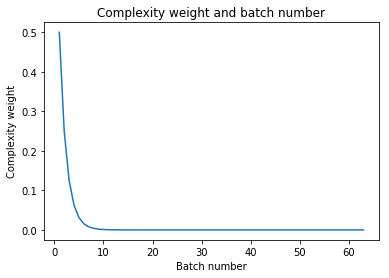

In [57]:
M = 100
_i = np.arange(1, M+1)
_y = 1 / (2 ** _i)
plt.plot(_i, _y)
plt.xlabel("Batch number")
plt.ylabel("Complexity weight")
plt.title("Complexity weight and batch number")

The idea behing this weighting scheme is that, initially, we do not want to weight the data too much as this would lead to very volatile distributions, since we've probably not inirialized the parameters very well. THe closer we get to high batch number, the more the influence of the data, when the inital conditions should not be important anymore.

# Application and Implementation

In this section, we implement the "Bayes By Backprop" algorithm in TensorFlow. We then apply the algorithm to the simulated dataset from above and the classical MNIST dataset.

## Implementation in TensorFlow

For an implementation in MXNet, see [this tutorial](https://gluon.mxnet.io/chapter18_variational-methods-and-uncertainty/bayes-by-backprop.html).

We define the parameters here so that we can easily modify them later.

In [4]:
config = {'n_hidden': [10, 10],
          'batch_size': 64,
          'learn_rate': 0.001,
          'num_samples': 1,
          'pi': 0.25,
          'sigma_p': 1.0,
          'sigma_p1': 0.75,
          'sigma_p2': 0.1}

In [238]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

class BBB:
    """
    Implentation of Bayes by Backprop
    """
    def __init__(self, n_input, n_output, n_hidden, batch_size=64, learn_rate=0.001, num_samples=1,
                 pi=0.25, sigma_p=1.0, sigma_p1=0.75, sigma_p2=0.1):
        
        self.n_input = n_input
        self.n_output = n_output
        self.n_hidden = n_hidden
        self.learn_rate = learn_rate
        self.pi = pi
        self.sigma_pi = 1.0,
        self.sigma_p1 = 0.75
        self.sigma_p2 = 0.1

        ## Construct neural network
        tf.reset_default_graph()
        #### Variational parameters
        mus = []
        rhos = []
        eps = []

        temp_mu = tf.Variable(tf.random_normal(shape=(n_input, n_hidden[0])))
        mus.append(temp_mu)

        temp_rho = tf.Variable(tf.constant(0.3, shape=(n_input, n_hidden[0])))
        rhos.append(temp_rho)

        temp_eps = tf.random_normal(shape=(n_input, n_hidden[0]))
        eps.append(temp_eps)

        for i in range(len(n_hidden)-1):
            temp_mu = tf.Variable(tf.random_normal(shape=(n_hidden[i], n_hidden[i+1])))
            temp_rho = tf.Variable(tf.constant(0.3, shape=(n_hidden[i], n_hidden[i+1])))
            temp_eps = tf.random_normal(shape=(n_hidden[i], n_hidden[i+1]))
            mus.append(temp_mu)
            rhos.append(temp_rho)
            eps.append(temp_eps)

        temp_mu = tf.Variable(tf.random_normal(shape=(n_hidden[-1], n_output)))
        temp_rho = tf.Variable(tf.constant(0.3, shape=(n_hidden[-1], n_output)))
        temp_eps = tf.random_normal(shape=(n_hidden[-1], n_output))

        mus.append(temp_mu)
        rhos.append(temp_rho)
        eps.append(temp_eps)

        ### Convert variational parameters to neural network weights (currently no bias terms)
        ws = [mu + e * tf.log(1+tf.exp(rho)) for (mu, e, rho) in zip(mus, eps, rhos)]

        ### Feed-forward
        self.x_in = tf.placeholder(tf.float32, shape=(None, n_input))

        for i in range(len(n_hidden)):
            if i == 0:
                x = tf.nn.relu(tf.matmul(self.x_in, ws[i]))
            else:
                x = tf.nn.relu(tf.matmul(x, ws[i]))

        logits = tf.matmul(x, ws[-1])
        self.y_out = tf.nn.softmax(logits)

        ### Actual values
        self.y_in = tf.placeholder(tf.int32, shape=(None))
        self.y = tf.one_hot(self.y_in, depth=n_output)
        #self.y = tf.placeholder(tf.float32, shape=(None, n_output))

        ### Loss
        #### Prior loss
        prior_gaussian = tfd.Normal(loc=0., scale=sigma_p)
        #### Stack mus and rhos to obtain tensor of variational parameters, plug into prior 
        #### Gaussian and sum
        var_pars = [tf.reshape(rho, [-1]) for rho in rhos] + [tf.reshape(mu, [-1]) for mu in mus]
        self.var_pars = tf.concat(var_pars, axis=0)
        self.prior_loss = tf.reduce_sum(prior_gaussian.log_prob(self.var_pars))
        tf.summary.scalar("prior_loss", self.prior_loss)

        #### Likelihood loss
        self.xent = tf.reduce_sum(
            tf.losses.softmax_cross_entropy(
                logits=logits, onehot_labels=self.y, reduction=tf.losses.Reduction.SUM), name="xent")
        tf.summary.scalar("xent", self.xent)

        #### Variational posterior loss
        posterior_loss = []
        for (mu, rho, w) in zip(mus, rhos, ws):
            #### Setup up loss distribution as Gaussian and append to posterior_loss
            foo = tfd.Normal(mu, tf.log(1+tf.exp(rho)))
            tmp_loss = tf.reduce_sum(tf.reshape(foo.log_prob(w), [-1]))
            posterior_loss.append(tmp_loss)

        self.posterior_loss = sum(posterior_loss)
        tf.summary.scalar("posterior_loss", self.posterior_loss)

        #### Combine posterior_loss into single tensor and tf.reduce_sum it

        #### Calculate total loss
        self.loss = - self.prior_loss + self.xent + self.posterior_loss
        tf.summary.scalar("loss", self.loss)

        #### Optimizer
        self.train_step = tf.train.AdamOptimizer(learn_rate).minimize(self.loss)
        
        self.summary = tf.summary.merge_all()
        self.writer = tf.summary.FileWriter(logdir='./logs')
        self.sess = tf.Session()
        
    def init(self):
        """
        Initialize session
        """
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
    def train(self, X, y, epochs, batch_size, silent=False, print_every=500):
        """
        Train Bayes By Backprop
        
        :param X: features
        :param y: target
        :param epochs: number of epochs to train
        """
        for i in range(epochs):
            _ = self.sess.run(self.train_step, feed_dict={self.x_in: X, self.y_in: y})
            if not silent and i % print_every == 0:
                loss_ = self.sess.run([self.loss, self.prior_loss, self.xent, self.posterior_loss], feed_dict={self.x_in: X, self.y_in: y})
                print(str(i) + ":  " + str(loss_) + "\r")
        
    def predict(self, X_new, n_samples):
        """
        Predict on new data
        
        :param X_new: new features on which to predict
        :param n_samples: int how many samples to predict
        """
        ys = np.zeros((n_samples, X_new.shape[0], self.n_output))
        for i in range(n_samples):
            foo = self.sess.run(self.y_out, feed_dict={self.x_in: X_new})
            ys[i, :, :] = foo
            
        return ys


## Concerete Dropout - An alternative to get uncertainties

Conrete Dropout [4] was introduced recently as a computationally efficient way to get model uncertainty for neural network. It is well justified theoretically as an approximation to the Gaussian process corresponding to neural networks. It allows to separate the *epistemic* and *aleatoric* uncertainity. The former is the uncertainty in the model weights (i.e. the uncertainty that goes away in the limit of infinite data. The *aleatoric* uncertainty, on the other hand, is the uncertainty coming from the sampling process, measurement errors etc.

Computationally, the fundamental idea is to leave *dropout "on"* at prediction time and thus obtain different Monte Carlo samples. The loss function is modified to a *heteroskedastic loss* so that we model the aleatoric uncertainty.

Even more concretrly, we make **predictions** by taking a number $N$ of samples and average them. A single MC samples consists of a pair $(\mu_i, \sigma_i)$. The *epistemic* uncertainty comes from the standard deviation of MC samples for the mean $sd(\mu_i)$. The *aleatoric* uncertainty is the *mean of the prediction of the standard deviation* $\frac{1}{N}\sum_i\sigma_i$..

## Simulated dataset

We continue using the same example of a simulated dataset we started with above. We apply both Bayes By Backprop and Concrete dropout to it.

### Bayes By Backprop

We start with Bayes By Backprop. The algorithm converges relatively quickly.

In [245]:
n_input = 2
n_output = 2
n_hidden = [10]
n_samp = 1000

X_train, y_train_ = make_classification(n_samples=n_samp, n_features=2, n_informative=2, n_redundant=0,
                           class_sep=0.5, random_state=0)

y_train = np.zeros((n_samp, 2))
y_train[y_train_ == 0, 0] = 1
y_train[y_train_ == 1, 1] = 1
    
    
bbb = BBB(n_input, n_output, n_hidden)
bbb.init()
bbb.train(X_train, y_train_, 45000, 1, print_every=2000)

0:  [2799.1025, -88.0671, 2765.813, -54.77752]
2000:  [536.55597, -98.29985, 452.0054, -13.749271]


KeyboardInterrupt: 

Let's plot the results on a new dataset. Looks very reasonable!

Text(0.5, 1.0, 'Posterior predictive ')

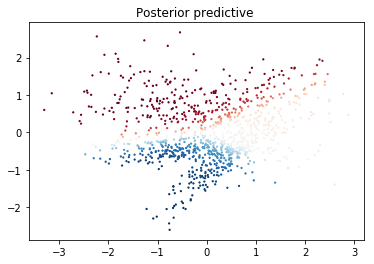

In [212]:
X_test, y_test = make_classification(n_samples=n_samp, n_features=2, n_informative=2, n_redundant=0,
                           class_sep=0.5, random_state=0)

pred = bbb.predict(X_test, 100).mean(axis=0)
cmap = cm.get_cmap('RdBu')
colors = [cmap(z) for z in pred[:, 0]]
plt.scatter(X_train[:, 0], X_train[:, 1], s=1.5, c=colors)
plt.title("Posterior predictive ")

In [213]:
pred = bbb.predict(X_test, 100).mean(axis=0)
test_acc = np.mean(y_test == pred.argmax(axis=1))
print("Test accuracy: {}".format(test_acc))

Test accuracy: 0.823


Another interesting plot is similar to one we saw above as well: we plot the predicted standard devation in probabilities at every point. The results make sense: near the "true decision boundary", the standard deviation is a lot higher.

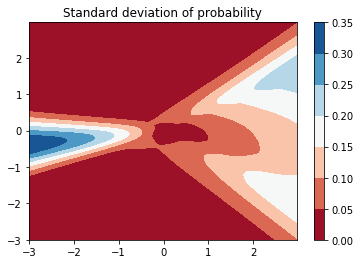

In [216]:
xy = np.mgrid[-3:3:0.03, -3:3:0.03]
X = xy.reshape(2, -1).T

pred = bbb.predict(X, 100).std(axis=0)[:, 0].reshape(xy.shape[1], xy.shape[2])

cmap = cm.get_cmap('RdBu')
plt.contourf(xy[0], xy[1], pred, cmap=cmap)
plt.title("Standard deviation of probability")
plt.colorbar()

### Concrete Dropout

We took the implementation for Concrete Dropout from [6].

In [180]:
from concrete_dropout import concrete_dropout

n_samples = 1000

import tensorflow as tf
from tensorflow import layers as tfl

tf.reset_default_graph()

def net(inputs, is_training):

    x = inputs

    dropout_params = {'init_min': 0.1, 'init_max': 0.1,
                      'weight_regularizer': 1e-6, 'dropout_regularizer': 1e-5,
                      'training': is_training}
    x, reg = concrete_dropout(x, name='1_dropout', **dropout_params)
    x, reg = concrete_dropout(x, name='2_dropout', **dropout_params)
    x = tfl.dense(x, 10, activation=tf.nn.relu, name='fc1',
                  kernel_regularizer=reg, bias_regularizer=reg)

    outputs = tfl.dense(x, 2, name='fc2')
    return outputs

x_train, y_train = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                           class_sep=0.5, random_state=0)


x_test, y_test = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                           class_sep=0.5, random_state=0)


x = tf.placeholder(tf.float32, [None, 2])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = net(x, is_training)

with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(
            labels=y, logits=y_out))
    loss += tf.reduce_sum(
            tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.RMSPropOptimizer(1e-4).minimize(loss)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_out, 1), y)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

dropout_rates = tf.get_collection('DROPOUT_RATES')
def rates_pretty_print(values):
    return {str(t.name): round(r, 4)
            for t, r in zip(dropout_rates, values)}

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        if i % 500 == 0:
            training_loss, training_acc, rates = sess.run(
                    [loss, accuracy, dropout_rates],
                    feed_dict={
                        x: x_train, y: y_train, is_training: False})
            print('step {}, loss {}, accuracy {}'.format(
                i, training_loss, training_acc))
            print('dropout rates: {}'.format(rates_pretty_print(rates)))
        train_step.run(feed_dict={
            x: x_train, y: y_train, is_training: True})
    accuracy, rates = sess.run([accuracy, dropout_rates],
                               feed_dict={x: x_test,
                                              y: y_test,
                                              is_training: False})
    
    preds = np.zeros((n_samples, X.shape[0], 2))
    for i in range(n_samples):
        foo = scipy.special.expit(sess.run(y_out, feed_dict={x: X, is_training: True}))
        preds[i, :, :] = foo

print('test accuracy {}'.format(accuracy))
print('final dropout rates: {}'.format(rates_pretty_print(rates)))

step 0, loss 0.554011881351471, accuracy 0.8029999732971191
dropout rates: {'1_dropout/dropout_rate:0': 0.1, '2_dropout/dropout_rate:0': 0.1}
step 500, loss 0.5026541948318481, accuracy 0.8209999799728394
dropout rates: {'1_dropout/dropout_rate:0': 0.0968, '2_dropout/dropout_rate:0': 0.0969}
step 1000, loss 0.4546899199485779, accuracy 0.8199999928474426
dropout rates: {'1_dropout/dropout_rate:0': 0.0929, '2_dropout/dropout_rate:0': 0.093}
step 1500, loss 0.41915273666381836, accuracy 0.8240000009536743
dropout rates: {'1_dropout/dropout_rate:0': 0.0891, '2_dropout/dropout_rate:0': 0.0892}
step 2000, loss 0.39933380484580994, accuracy 0.8289999961853027
dropout rates: {'1_dropout/dropout_rate:0': 0.0854, '2_dropout/dropout_rate:0': 0.0854}
step 2500, loss 0.38830631971359253, accuracy 0.8360000252723694
dropout rates: {'1_dropout/dropout_rate:0': 0.0819, '2_dropout/dropout_rate:0': 0.0819}
step 3000, loss 0.38172727823257446, accuracy 0.8399999737739563
dropout rates: {'1_dropout/dropo

We see the concrete dropout gets very good test results, slightly better than Bayes By Backprop.

## MNIST

We now move on to apply both Bayes By Backprop and Concrete Dropout to the famous MNIST dataset.

### Bayes By Backprop

**TODO: APPLY BAYES BY BACKPROP HERE AND COMMENT ON RESULTS**

In [268]:
from tensorflow.examples.tutorials.mnist import input_data

n_input = 784
n_output = 10
n_hidden = [128, 256, 512]

batch_size = 1000
n_epochs = 1000

mnist = input_data.read_data_sets('MNIST_data') 

bbb = BBB(n_input, n_output, n_hidden, learn_rate=0.01)
bbb.init()
    
for i in range(n_epochs):
    for j in range(60000 // batch_size):
        X_train, y_train = mnist.train.next_batch(batch_size)
        X_train = X_train.reshape(-1, 784)
        bbb.train(X_train, y_train, 1, 1, silent=True)
    
    X_test, y_test = mnist.train.next_batch(5000)
    X_test = X_test.reshape(-1, 784)

    pred = bbb.predict(X_test, 10).mean(axis=0)
    test_acc = np.mean(y_test == pred.argmax(axis=1))
    print("Test accuracy: {}".format(test_acc))
    
    X_train, y_train = mnist.train.next_batch(5000)
    X_train = X_train.reshape(-1, 784)
    
    pred = bbb.predict(X_train, 10).mean(axis=0)
    train_acc = np.mean(y_train == pred.argmax(axis=1))
    print("Train accuracy: {}".format(train_acc))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Test accuracy: 0.3008
Train accuracy: 0.282
Test accuracy: 0.3224
Train accuracy: 0.3246
Test accuracy: 0.307
Train accuracy: 0.3032
Test accuracy: 0.2908
Train accuracy: 0.2568
Test accuracy: 0.2672
Train accuracy: 0.2734
Test accuracy: 0.2808
Train accuracy: 0.2228
Test accuracy: 0.2404
Train accuracy: 0.257
Test accuracy: 0.2458
Train accuracy: 0.23
Test accuracy: 0.222
Train accuracy: 0.2412


KeyboardInterrupt: 

### Concrete Dropout

We run the concrete dropout algorithm.

In [252]:
tf.reset_default_graph()

def net(inputs, is_training):

    x = tf.reshape(inputs, [-1, 784], name='flatten')

    dropout_params = {'init_min': 0.1, 'init_max': 0.1,
                      'weight_regularizer': 1e-6, 'dropout_regularizer': 1e-5,
                      'training': is_training}
    
    
    x, reg = concrete_dropout(x, name='conv1_dropout', **dropout_params)
    x = tfl.dense(x, 256, activation=tf.nn.relu, 
                   kernel_regularizer=reg, bias_regularizer=reg,
                   name='conv1')

    x, reg = concrete_dropout(x, name='conv2_dropout', **dropout_params)
    x = tfl.dense(x, 512, activation=tf.nn.relu,
                   kernel_regularizer=reg, bias_regularizer=reg,
                   name='conv2')

    x, reg = concrete_dropout(x, name='fc1_dropout', **dropout_params)
    x = tfl.dense(x, 1024, activation=tf.nn.relu, name='fc1',
                  kernel_regularizer=reg, bias_regularizer=reg)

    outputs = tfl.dense(x, 10, name='fc2')
    return outputs


mnist = input_data.read_data_sets('MNIST_data')

x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = net(x, is_training)

with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(
            labels=y, logits=y_out))
    loss += tf.reduce_sum(
            tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.RMSPropOptimizer(1e-4).minimize(loss)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_out, 1), y)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

dropout_rates = tf.get_collection('DROPOUT_RATES')
def rates_pretty_print(values):
    return {str(t.name): round(r, 4)
            for t, r in zip(dropout_rates, values)}

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(20000):
        batch = mnist.train.next_batch(50)
        if i % 500 == 0:
            training_loss, training_acc, rates = sess.run(
                    [loss, accuracy, dropout_rates],
                    feed_dict={
                        x: batch[0], y: batch[1], is_training: False})
            print('step {}, loss {}, accuracy {}'.format(
                i, training_loss, training_acc))
            print('dropout rates: {}'.format(rates_pretty_print(rates)))
        train_step.run(feed_dict={
            x: batch[0], y: batch[1], is_training: True})
    accuracy, rates = sess.run([accuracy, dropout_rates],
                               feed_dict={x: mnist.test.images,
                                              y: mnist.test.labels,
                                              is_training: False})

print('test accuracy {}'.format(accuracy))
print('final dropout rates: {}'.format(rates_pretty_print(rates)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, loss 2.2620320320129395, accuracy 0.11999999731779099
dropout rates: {'conv1_dropout/dropout_rate:0': 0.1, 'conv2_dropout/dropout_rate:0': 0.1, 'fc1_dropout/dropout_rate:0': 0.1}
step 500, loss 0.39936888217926025, accuracy 0.8799999952316284
dropout rates: {'conv1_dropout/dropout_rate:0': 0.0978, 'conv2_dropout/dropout_rate:0': 0.0977, 'fc1_dropout/dropout_rate:0': 0.0981}
step 1000, loss 0.2874773144721985, accuracy 0.9200000166893005
dropout rates: {'conv1_dropout/dropout_rate:0': 0.0956, 'conv2_dropout/dropout_rate:0': 0.0957, 'fc1_dropout/dropout_rate:0': 0.097}
step 1500, loss 0.21518556773662567, accuracy 0.8999999761581421
dropout rates: {'conv1_dropout/dropout_rate:0': 0.0937, 'conv2_dropout/dropout_rate:0': 0.0934, 'fc1_dropout/dropout_rate:0': 0.0961}
step 2000, loss 0.2422857

We reach an accuracy of around 98% with conrete dropout.

### Comparison

**TODO: WRITE COMPARISON*

# Connection to ADVI

A very short time after [1] was published, the paper ["Automatic Variational Inference in Stan"](https://arxiv.org/pdf/1506.03431.pdf)[2], was published (for a good practical introduction to ADVI, see the [PyMC3 docs](https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html)). We'll give a brief overview of ADVI and then explain how it compares to "Bayes by Backprop".

## ADVI

ADVI is an algorithm to do variational inference automatically, using the automatic computation of derivatives that is available in modern software packages like Stan, TensorFlow or pymc3. It is applicable to all variational problems except for purely discrete ones (like the Ising model).

One of the key challenges of variational inference for a long time was that algorithms the optimization algorithm had to be derived for each and every problem. We were restricted to condionally conjugate families and the custom appoximation algorithm had to be found for every such specification. Applying standard optimization techniques like stochastic gradient descent was not easily possible, since the **support constraints** (the "allowed values" of the parameteres) of the parameters had to be satisfied.

ADVI solves this problem by applying a **coordinate tranformation** approach: we apply a coorindate transformation to every continuous parameter so that in the new coordinate system we have an **unconstrained optimization problem**. Then we impose a diagonal Gaussian prior in the new coordinate system. Note that this *does not impose a Gaussian prior on the original parameters*, since we have to multiply by the Jacobian of the transformation.

Let's copy down the algorithm from [2] so that we have a direct comparison to "Bayes by backprop":

>>
**ADVI**
1. Draw samples from $\mathcal N(0, {\bf I})$.
2. Invert standardization to obtain $\zeta_m = \mu + (\exp \rho) \eta$
3. Approximate $\nabla_\mu \mathcal L$ and $\nabla_\rho \mathcal L$ using MC integration.
4. Update $\mu \rightarrow \mu + \alpha \nabla_\mu \mathcal L$, $\rho \rightarrow \rho + \alpha \nabla_\rho \mathcal L$.
>>

Here $\alpha$ is the learning rate and we initialized the posterior parameteres $\mu, \omega$ in some fashion, e.g. $\mu = 0$, $\rho = 0$.

## ADVI and Bayes By Backprop

In this section, we'll finally show that **Bayes By Backprop is a special case of ADVI applied to the weights of a neural network**, if we assume 

To start with, we see that both algorithms look very similar. Both start with sampling from a diagonal Gaussian. The samples from this Gaussian are then transformed from $(\mu, \rho) \in \mathbb R^n \times \mathbb R^n$ to $(\mu, \sigma) \in \mathbb R^n \times \mathbb R_+^n$ space, the space of posterior means and standard deviations. 

This tranformations is slightly differnt between ADVI and Bayes by Backprop. In [3] the senisitvity to these different transformations is examined and the transformation proposed in [1] is shown to yield very similar results to the ADVI given above.

After this transformation, the next steps (weight computation, gradient computation and parameter update) are identical.

In summary, we have shown here that Bayes by backprop is a special case of ADVI and thus we can use all the technology developed in packages like pymc3 to perform inference.

# Summary

In this project we looked at Bayesian neural networks. We motivated a variational approch by seeing how naive MCMC fails even with small dataset sizes and showed the mathematics of a particular implementation of variational inference, namely **Bayes By Backprop** which applies gradient descent optimization to solve the variational inference problem.

We implemented this algorithm in TensorFlow and applied it to a fake, standard dataset from scikit-learn, and then to MNIST. Finally, we showed that Bayes By Backprop fits into the more general idea of ADVI and compared its performance to Concrete Dropout. The results are summarized in **TODO: THE TABLE BELOW**.

# References

+ 1: Blundell, Charles, et al. "Weight uncertainty in neural networks." arXiv preprint arXiv:1505.05424 (2015).https://arxiv.org/pdf/1505.05424.pdf
+ 2: Kucukelbir, Alp, et al. "Automatic variational inference in Stan." Advances in neural information processing systems. 2015.
+ 3: Kucukelbir, Alp, et al. "Automatic differentiation variational inference." The Journal of Machine Learning Research 18.1 (2017): 430-474.
+ 4: Gal, Yarin, Jiri Hron, and Alex Kendall. "Concrete dropout." Advances in Neural Information Processing Systems. 2017.
+ 5: https://gluon.mxnet.io/chapter18_variational-methods-and-uncertainty/bayes-by-backprop.html
+ 6: https://github.com/Skydes